In [135]:
from deep_dating.networks import DatingCNN
from deep_dating.datasets import DatingDataLoader, DatasetName, SetType
from deep_dating.util import SEED
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [2]:
model = DatingCNN()
model.load_state_dict(torch.load("runs/Dec21-16-31-47/model_epoch_8.pt"))
model.base_model.fc = nn.Identity()
model.eval()

DatingCNN(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

In [3]:
val_loader = DatingDataLoader(DatasetName.MPS, SetType.VAL, model)

all_outputs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):

        labels = labels.unsqueeze(1)
        all_labels.append(labels)
        
        outputs = model(inputs)
        all_outputs.append(outputs)

100%|██████████| 1204/1204 [23:57<00:00,  1.19s/it]


In [4]:
all_outputs_np = np.concatenate(all_outputs)
print(all_outputs_np.shape)
np.save("feat_val.npy", all_outputs_np, allow_pickle=True)

all_labels_np = np.concatenate(all_labels)
print(all_labels_np.shape)
np.save("feat_labels_val.npy", all_labels_np, allow_pickle=True)

(19251, 2048)
(19251, 1)


In [77]:
features = np.load("feat_val.npy", allow_pickle=True)
labels = np.load("feat_labels_val.npy", allow_pickle=True).astype(int).flatten()

In [80]:
unique_labels = list(np.unique(labels))
num_unique_labels = len(unique_labels)
print(f"{num_unique_labels} unique labels:", unique_labels)
colors = sns.color_palette('Spectral', n_colors=num_unique_labels)

11 unique labels: [1300, 1325, 1350, 1375, 1400, 1425, 1450, 1475, 1500, 1525, 1550]


In [128]:
def get_date_dict(reduced_features):
    dict_ = {}

    for i, x in enumerate(labels):
        val = reduced_features[i, :]
        if x not in dict_:
            dict_[x] = [val]
        else:
            dict_[x].append(val)

    for key in dict_.keys():
        dict_[key] = np.vstack(dict_[key])

    return dict_

def plot_dims(reduced_features, axs_name, in_3d=False):
    dict_ = get_date_dict(reduced_features)
    keys = sorted(dict_.keys())
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection="3d") if in_3d else plt.gca()

    for i, key in enumerate(keys):
        arr = dict_[key]
        z = arr[:, 2] if in_3d else None
        ax.scatter(arr[:, 0], arr[:, 1], z, color=colors[i], label=str(key))

    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Date")
    plt.xlabel(axs_name + " 1")
    plt.ylabel(axs_name + " 2")
    if in_3d:
        ax.set_zlabel(axs_name + " 3")
    plt.show()

## PCA

In [32]:
pca = PCA(n_components=features.shape[1], random_state=SEED)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_pca = pca.fit_transform(features_scaled)

First 10 components: [9.6768036e+01 1.3520852e+00 7.1046221e-01 2.7738211e-01 1.5293215e-01
 9.8083682e-02 6.0386192e-02 5.3859323e-02 4.7997139e-02 4.6434570e-02]


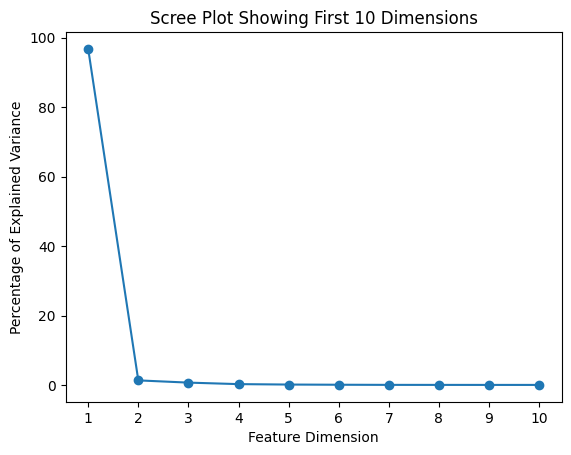

In [54]:
n = 10
x = np.arange(1, pca.n_components_ + 1)[:n]
var_explained = (pca.explained_variance_ratio_ * 100)[:n]
plt.plot(x, var_explained, "o-")
print("First", n, "components:", var_explained)
plt.xticks(x)
plt.xlabel("Feature Dimension")
plt.ylabel("Percentage of Explained Variance")
plt.title(f"Scree Plot Showing First {n} Dimensions")
plt.show()

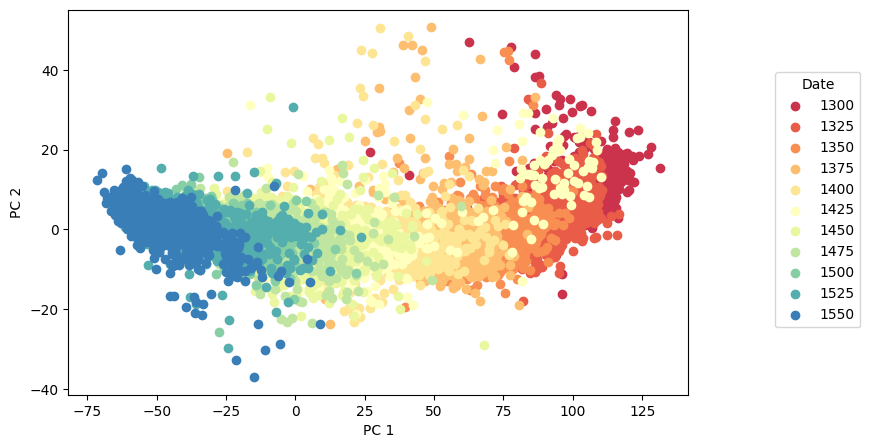

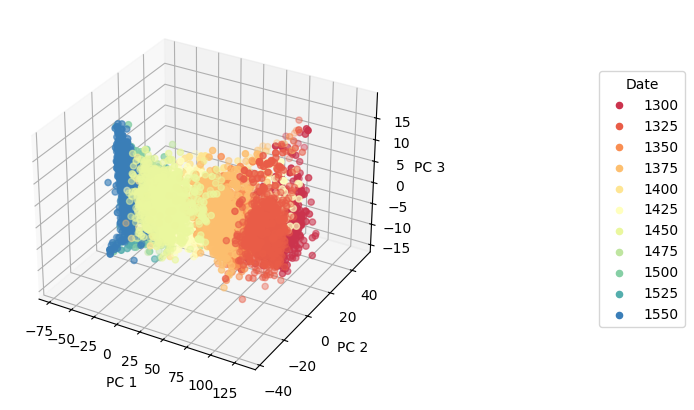

In [129]:
plot_dims(features_pca, "PC")
plot_dims(features_pca, "PC", in_3d=True)

## TSNE

In [131]:
perplexity=30
tsne_2d = TSNE(n_components=2, perplexity=perplexity, random_state=SEED, n_jobs=-1)
features_tsne_2d = tsne_2d.fit_transform(features)
tsne_3d = TSNE(n_components=3, perplexity=perplexity, random_state=SEED, n_jobs=-1)
features_tsne_3d = tsne_3d.fit_transform(features)

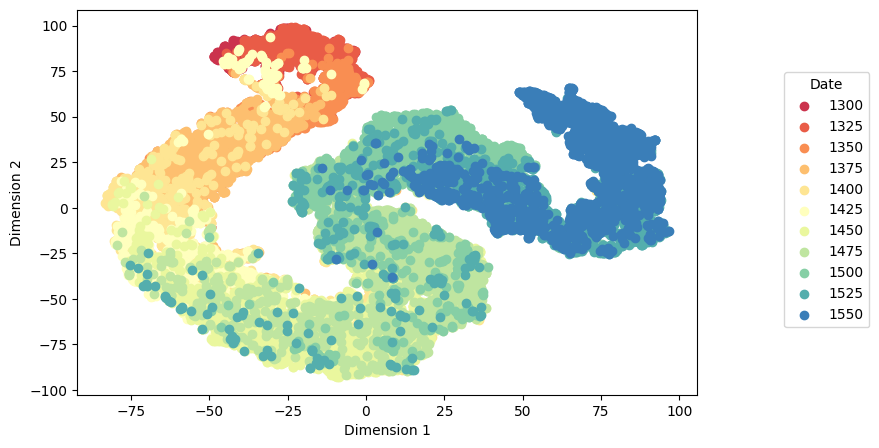

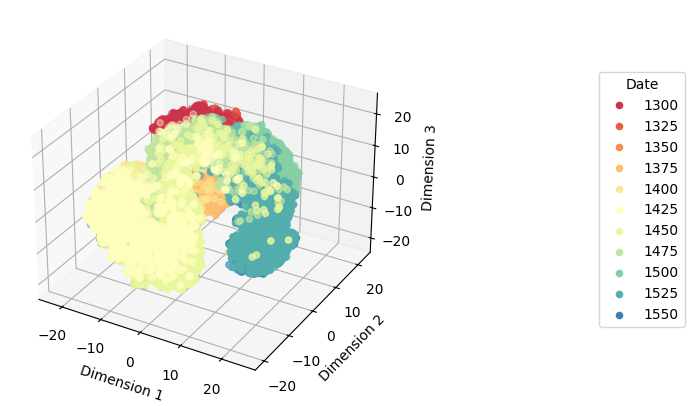

In [132]:
plot_dims(features_tsne_2d, "Dimension")
plot_dims(features_tsne_3d, "Dimension", in_3d=True)

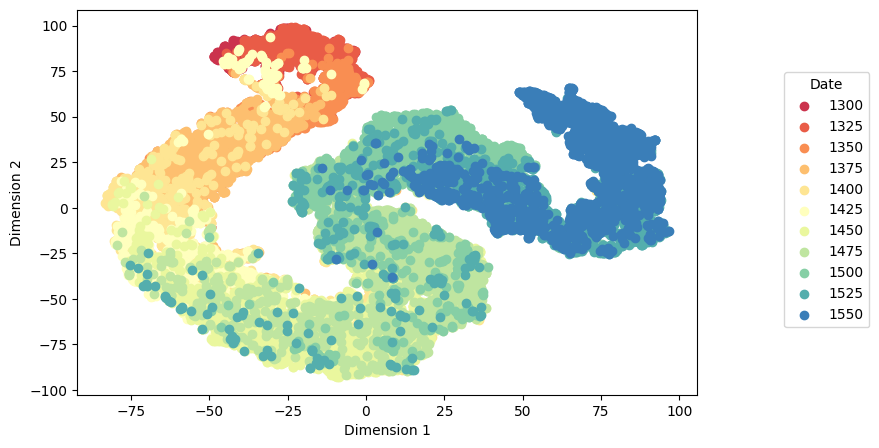

## SVM

In [136]:
train_feat, test_feat, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=SEED)

In [150]:
def mae(true, pred):
    pred = np.round(pred)
    n = np.max(pred.shape)
    return np.sum(np.abs(true - pred)) / n

def mse(true, pred):
    pred = np.round(pred)
    n = np.max(pred.shape)
    return np.sum(np.square(true - pred)) / n

def cs(true, pred):
    alphas = np.arange(0, 51)
    pred = np.round(pred)
    n = np.max(pred.shape)
    diff = np.abs(true - pred)
    return [(np.count_nonzero(diff <= a) / n) * 100 for a in alphas]

In [138]:
print(train_feat.shape)
svm = SVR(kernel="rbf")
svm.fit(train_feat, train_labels)

(13475, 2048)


SVR()

In [142]:
predict = svm.predict(test_feat)

12.534452908587257
357.36443905817174


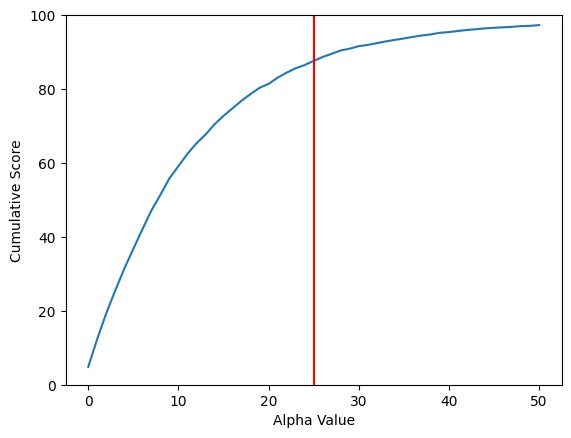

In [155]:
cs_ = cs(test_labels, predict)
print(mae(test_labels, predict))
print(mse(test_labels, predict))

plt.plot(np.arange(0, 51), cs_)
plt.xlabel("Alpha Value")
plt.ylabel("Cumulative Score")
plt.ylim(0, 100)
plt.axvline(x=25, color="red")
plt.show()